*Read section 8.2.1 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

## Bagging: A Variance Reduction Technique

Bagging, short for **Bootstrap Aggregating**, is an effective way to reduce overfitting in decision trees. It works by training multiple decision trees—each on a different bootstrap sample of the data—and then aggregating their predictions.

Each individual decision tree is a **weak learner** and prone to overfitting, but by combining many such trees, bagging produces a **strong learner** with **lower variance** and improved generalization performance.

The number of trees to include in the ensemble is specified by the `n_estimators` hyperparameter.

In [9]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.35)

# import the decision tree regressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import BaggingRegressor,BaggingClassifier

# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split


from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer, accuracy_score

## Bagging regression trees


Let's revisit the same dataset used for building a single regression tree and explore whether we can further improve its performance using bagging

In [3]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


Split the predictors and target, then perform the train-test split

In [4]:
X = car.drop(columns=['price'])
y = car['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

Encode categorical predictors

In [5]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_feature])
X_test_encoded = encoder.transform(X_test[categorical_feature])

# Convert the encoded features back to DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_feature))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_feature))

# Concatenate the encoded features with the original numerical features
X_train_final = pd.concat([X_train_encoded_df, X_train[numerical_feature].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df, X_test[numerical_feature].reset_index(drop=True)], axis=1)

By default, a single decision tree grows to its full depth, which often leads to overfitting as shown below

In [15]:
# build a decision tree regressor using the default parameters
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_final, y_train)
y_pred = tree_reg.predict(X_test_final)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}, test R^2: {r2:.2f}")

# training rmse and r2
y_train_pred = tree_reg.predict(X_train_final)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train RMSE: {train_rmse:.2f}, train R^2: {train_r2:.2f}")

# print the depth of the tree
print(f"Depth of the tree: {tree_reg.get_depth()}")
# print the number of leaves in the tree
print(f"Number of leaves in the tree: {tree_reg.get_n_leaves()}")

Test RMSE: 6219.96, test R^2: 0.87
Train RMSE: 0.00, train R^2: 1.00
Depth of the tree: 34
Number of leaves in the tree: 5925


As observed, the model achieves an RMSE of 0.00 and an R² of 100% on the training data with default parameters, indicating overfitting

To address this, we’ve previously explored pre-pruning and post-pruning techniques. Another effective approach is bagging, which helps reduce overfitting by lowering model variance. 

Next, we’ll explore how bagging can improve the performance of unpruned decision trees by reducing variance

In [ ]:
#Bagging the results of 10 decision trees with the default parameters to predict car price
bagging_reg = BaggingRegressor(random_state=1, 
                        n_jobs=-1).fit(X_train_final, y_train)

# make predictions on the test set
y_pred_bagging = bagging_reg.predict(X_test_final)

# calculate the RMSE and R^2 score
rmse_bagging = root_mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

print("Test RMSE with Bagging unpruned trees:", round(rmse_bagging, 2))
print("Test R^2 score with Bagging unpruned trees:", round(r2_bagging, 2))

# training RMSE and R^2 score
y_pred_train_bagging = bagging_reg.predict(X_train_final)

# calculate the RMSE and R^2 score
rmse_train_bagging = root_mean_squared_error(y_train, y_pred_train_bagging)
r2_train_bagging = r2_score(y_train, y_pred_train_bagging)

print("Train RMSE with Bagging unpruned trees:", round(rmse_train_bagging, 2))
print("Train R^2 score with Bagging unpruned trees:", round(r2_train_bagging, 2))


Test RMSE with Bagging unpruned trees: 3758.1
Test R^2 score with Bagging unpruned trees: 0.95
Train RMSE with Bagging unpruned trees: 1501.04
Train R^2 score with Bagging unpruned trees: 0.99


With the default settings, bagging unpruned trees improves performance, reducing the RMSE from 6219.96 to 3758.10 and increasing the R² score from 0.87 to 0.95.

What about bagging pruned trees? Since pruning improves the performance of a single decision tree, does that mean bagging pruned trees will also outperform bagging unpruned trees? Let’s find out through implementation.

Below is the [best model](https://lizhen0909.github.io/STAT303-3-class-notes/regression_tree_sp25.html#key-hyperparameters-in-decision-tree) obtained by tuning the hyperparameters of a single decision tree.

In [16]:
# fit the decision tree regressor
pruned_tree_reg = DecisionTreeRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=5, random_state=42)
pruned_tree_reg.fit(X_train_final, y_train)

# make predictions on the test set
y_pred = pruned_tree_reg.predict(X_test_final)
# calculate the RMSE and R^2 score
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print the RMSE and R^2 score, keep the decimal points to 2
print("Test RMSE:", round(rmse, 2))
print("Test R^2 score:", round(r2, 2))

#print the depth of the tree
print(f"Depth of the tree: {pruned_tree_reg.get_depth()}")
#print the number of leaves in the tree
print(f"Number of leaves in the tree: {pruned_tree_reg.get_n_leaves()}")

Test RMSE: 4726.17
Test R^2 score: 0.92
Depth of the tree: 33
Number of leaves in the tree: 2558


Next, let’s apply bagging to these pruned trees using the default settings.

In [ ]:
#Bagging the results of 10 decision trees to predict car price
bagging_reg = BaggingRegressor(estimator=pruned_tree_reg, random_state=1,
                        n_jobs=-1).fit(X_train_final, y_train)

# make predictions on the test set
y_pred_bagging = bagging_reg.predict(X_test_final)

# calculate the RMSE and R^2 score
rmse_bagging = root_mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

print("Test RMSE with Bagging pruned trees:", round(rmse_bagging, 2))
print("Test R^2 score with Bagging pruned trees:", round(r2_bagging, 2))


# training RMSE and R^2 score
y_pred_train_bagging = bagging_reg.predict(X_train_final)

# calculate the RMSE and R^2 score
rmse_train_bagging = root_mean_squared_error(y_train, y_pred_train_bagging)
r2_train_bagging = r2_score(y_train, y_pred_train_bagging)

print("Train RMSE with Bagging pruned trees:", round(rmse_train_bagging, 2))
print("Train R^2 score with Bagging pruned trees:", round(r2_train_bagging, 2))


Test RMSE with Bagging pruned trees: 3806.7
Test R^2 score with Bagging pruned trees: 0.95
Train RMSE with Bagging pruned trees: 1868.7
Train R^2 score with Bagging pruned trees: 0.99


Compared to bagging the unpruned trees, the performance is slightly worse, with bagging pruned trees the RMSE is 3806.7, bagging the unpruned trees lead to RMSe 3758.1.

**Why is bagging tuned trees worse than bagging untuned trees?**

In the pruned tree, limiting the maximum depth reduces variance but increases bias, as reflected by the smaller depth and fewer leaves compared to the unpruned tree. Since bagging only reduces variance and does not affect bias, applying it to pruned trees—which have slightly higher bias—results in slightly worse performance than bagging unpruned trees


  
This suggests that when using bagging, we don’t necessarily need to tune the hyperparameters of the base decision tree—bagging itself effectively combats overfitting by reducing variance, much like hyperparameter tuning does.

## Bagging Doesn’t Reduce Bias

Bagging high-variance models can effectively lower overall variance, as long as the individual models are not highly correlated. However, Bagging high-bias models will still produce a high-bias ensemble.

To demonstrate this, we first fit a **shallow decision tree** with `max_depth=2`, which severely underfits the data due to its limited capacity. Then, we apply **bagging** using 10 such shallow trees (default setting) as base estimators.

Since each tree has high bias, the aggregated predictions from bagging still inherit that bias. In our results, both the single shallow tree and the bagged version yield similar (and poor) performance in terms of RMSE and R² on both the training and test sets.

This experiment shows that if your base model is too simple to capture the underlying patterns in the data, bagging will not help. To improve performance in such cases, we need to use more expressive base models or consider methods like **boosting**, which are better suited to reducing both bias and variance. 

In [17]:
# Single shallow decision tree (underfitting)
shallow_tree_reg = DecisionTreeRegressor(max_depth=2, random_state=1)
shallow_tree_reg.fit(X_train_final, y_train)

# Predict and evaluate on test set
y_pred_single = shallow_tree_reg.predict(X_test_final)
rmse_single = root_mean_squared_error(y_test, y_pred_single)
r2_single = r2_score(y_test, y_pred_single)

# Predict and evaluate on training set
y_pred_train_single = shallow_tree_reg.predict(X_train_final)
rmse_train_single = root_mean_squared_error(y_train, y_pred_train_single)
r2_train_single = r2_score(y_train, y_pred_train_single)

print("Single Shallow Tree - Test RMSE:", round(rmse_single, 2))
print("Single Shallow Tree - Test R^2:", round(r2_single, 2))
print("Single Shallow Tree - Train RMSE:", round(rmse_train_single, 2))
print("Single Shallow Tree - Train R^2:", round(r2_train_single, 2))

Single Shallow Tree - Test RMSE: 11084.97
Single Shallow Tree - Test R^2: 0.58
Single Shallow Tree - Train RMSE: 10314.42
Single Shallow Tree - Train R^2: 0.6


Let's bag these shallow trees

In [18]:

# Bagging with 10 shallow trees
bagging_shallow = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=2, random_state=1),
                                    random_state=1,
                                    n_jobs=-1)
bagging_shallow.fit(X_train_final, y_train)

# Predict and evaluate on test set
y_pred_bagging = bagging_shallow.predict(X_test_final)
rmse_bagging = root_mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

# Predict and evaluate on training set
y_pred_train_bagging = bagging_shallow.predict(X_train_final)
rmse_train_bagging = root_mean_squared_error(y_train, y_pred_train_bagging)
r2_train_bagging = r2_score(y_train, y_pred_train_bagging)

print("Bagged Shallow Trees - Test RMSE:", round(rmse_bagging, 2))
print("Bagged Shallow Trees - Test R^2:", round(r2_bagging, 2))
print("Bagged Shallow Trees - Train RMSE:", round(rmse_train_bagging, 2))
print("Bagged Shallow Trees - Train R^2:", round(r2_train_bagging, 2))

Bagged Shallow Trees - Test RMSE: 10894.92
Bagged Shallow Trees - Test R^2: 0.6
Bagged Shallow Trees - Train RMSE: 10114.07
Bagged Shallow Trees - Train R^2: 0.62


✅ What you should observe:

- **Both models show low R² and high RMSE due to the shallow depth (`max_depth=2`).**
- **Bagging cannot fix the high bias inherent in a shallow decision tree.**

## Model Performance vs. Number of Trees

To better understand how the number of base estimators affects the performance of a bagging model, we evaluate the test RMSE and R² score across different numbers of trees.  
This analysis helps us determine whether adding more trees continues to improve performance or if the model reaches a performance plateau.

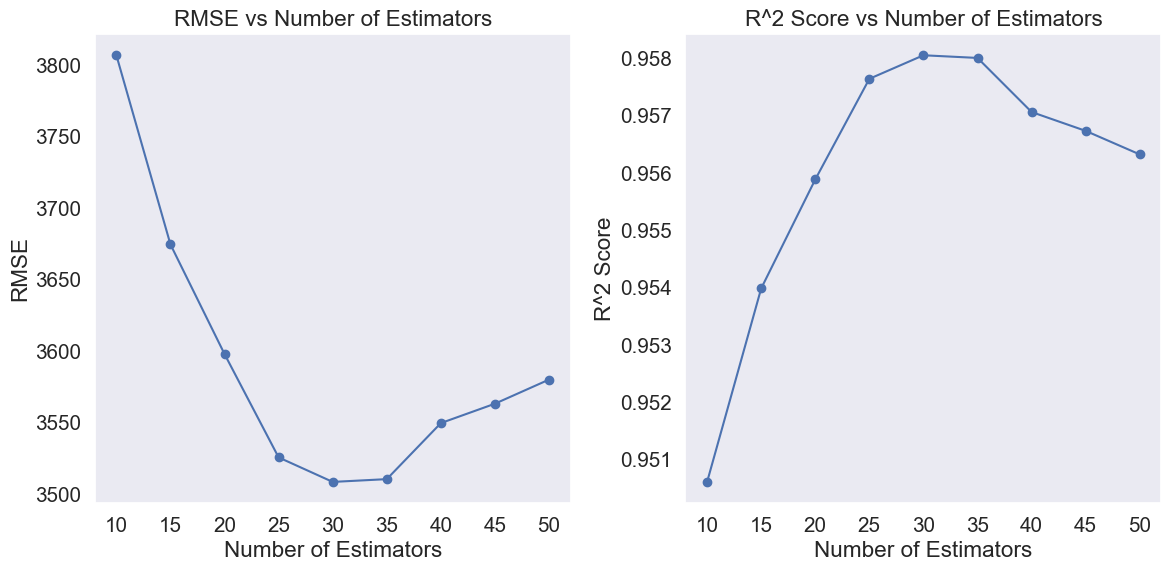

In [23]:
# explore how the number of estimators affects the performance of the model, output both oob and test scores
n_estimators = [ 10, 15, 20, 25,30, 35, 40, 45, 50]
rmse_scores = []
r2_scores = []

# iterate through the number of estimators and fit the model
for n in n_estimators:
    bagging_reg = BaggingRegressor(estimator=pruned_tree_reg, n_estimators=n, random_state=1,
                        n_jobs=-1).fit(X_train_final, y_train)
    y_pred_bagging = bagging_reg.predict(X_test_final)
    rmse_scores.append(np.sqrt(np.mean((y_test - y_pred_bagging) ** 2)))
    r2_scores.append(r2_score(y_test, y_pred_bagging))

# plot the RMSE and R^2 scores against the number of estimators
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_estimators, rmse_scores, marker='o')
plt.title('RMSE vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.xticks(n_estimators)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(n_estimators, r2_scores, marker='o')
plt.title('R^2 Score vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.xticks(n_estimators)
plt.grid()
plt.tight_layout()
plt.show()

**Quick Takeaway**

- **Increasing the number of estimators initially improves performance**, as seen from the decreasing RMSE and increasing R² scores.
- **Performance stabilizes around 30–35 estimators**. Beyond this point, additional trees provide minimal gains.
- Due to the small and possibly noisy test set, performance may appear to **peak and then decline slightly**. However, this is not typical—under normal circumstances, performance **levels off and forms a plateau**.


In [24]:
# get the number of estimators that gives the best RMSE score
best_rmse_index = np.argmin(rmse_scores)
best_rmse_n_estimators = n_estimators[best_rmse_index]
best_rmse_value = rmse_scores[best_rmse_index]
print("Best number of estimators for RMSE:", best_rmse_n_estimators)
print("Best RMSE value:", round(best_rmse_value, 2))

# get the number of estimators that gives the best R^2 score
best_r2_index = np.argmax(r2_scores)
best_r2_n_estimators = n_estimators[best_r2_index]
best_r2_value = r2_scores[best_r2_index]
print("Best number of estimators for R^2 score:", best_r2_n_estimators)
print("Best R^2 score:", round(best_r2_value, 2))

Best number of estimators for RMSE: 30
Best RMSE value: 3508.31
Best number of estimators for R^2 score: 30
Best R^2 score: 0.96


##  OOB Sample and OOB Score in Bagging

When training a **Bagging ensemble**, such as `BaggingClassifier` or `BaggingRegressor`, each base learner is trained on a **bootstrap sample**—a random sample *with replacement* from the original dataset.

###  What is an OOB Sample?

For each base learner, the data points **not selected** in the bootstrap sample form its **Out-of-Bag (OOB) sample**. On average, about **1/3 of the original data points** are not included in each bootstrap sample. These unused samples are called **OOB samples**.

###  What is OOB Score?

Each base learner can be evaluated on its corresponding OOB sample—i.e., the instances it did *not* see during training. This provides a **built-in validation mechanism** without needing an explicit validation set or cross-validation.

The OOB score is the **average performance** (e.g., accuracy for classifiers, R² for regressors) of the ensemble evaluated on OOB samples.

> 🔧 **Note:** By default, the `oob_score` option is turned **off** in scikit-learn. You must explicitly set `oob_score=True` to enable it, as shown below.

```python
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=100,
    oob_score=True,
    random_state=42
)
bagging_clf.fit(X_train, y_train)

# Access the OOB score
print(f"OOB Score: {bagging_clf.oob_score_:.4f}")
```

c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


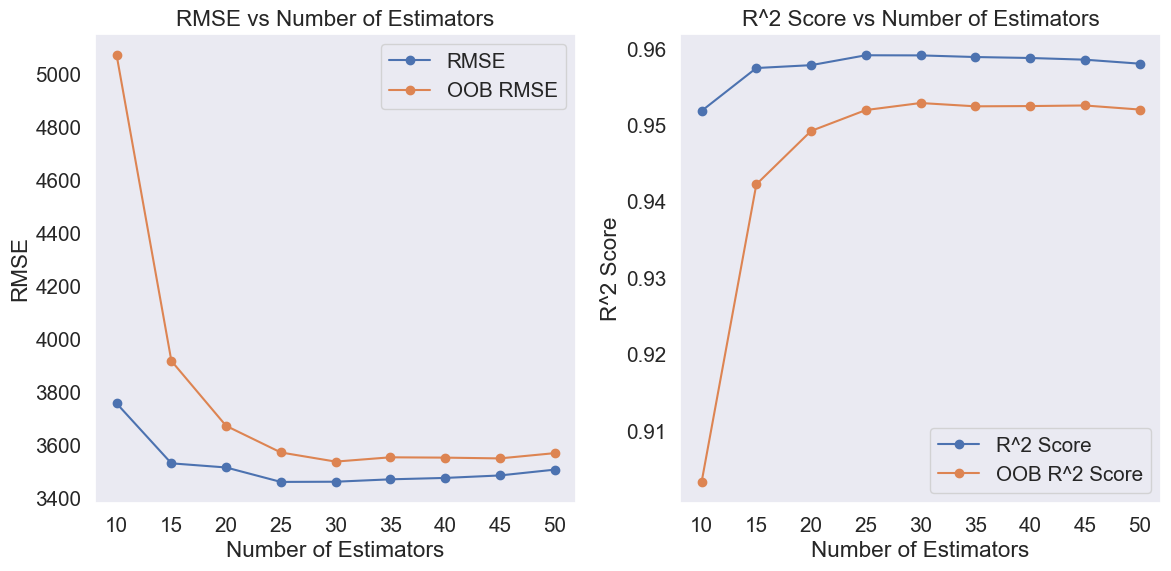

In [27]:
n_estimators = [ 10, 15, 20, 25,30, 35, 40, 45, 50]
rmse_scores = []
r2_scores = []
oob_scores = []
oob_rmse_scores = []
for n in n_estimators:
    bagging_reg = BaggingRegressor(estimator=tree_reg, n_estimators=n, oob_score=True, random_state=1,
                        n_jobs=-1).fit(X_train_final, y_train)
    y_pred_bagging = bagging_reg.predict(X_test_final)
    rmse_scores.append(np.sqrt(np.mean((y_test - y_pred_bagging) ** 2)))
    r2_scores.append(r2_score(y_test, y_pred_bagging))
    oob_scores.append(bagging_reg.oob_score_)
    oob_rmse_scores.append(np.sqrt(np.mean((y_train - bagging_reg.oob_prediction_) ** 2)))

# plot the RMSE and R^2 scores against the number of estimators
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_estimators, rmse_scores, marker='o')
plt.plot(n_estimators, oob_rmse_scores, marker='o')
plt.legend(['RMSE', 'OOB RMSE'])
plt.title('RMSE vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.xticks(n_estimators)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(n_estimators, r2_scores, marker='o')
plt.plot(n_estimators, oob_scores, marker='o')
plt.legend(['R^2 Score', 'OOB R^2 Score'])
plt.title('R^2 Score vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.xticks(n_estimators)
plt.grid()
plt.tight_layout()
plt.show()

**Quick Takeaway**

- **OOB estimates become more reliable** as the number of trees grows, with OOB scores closely tracking the test performance after around 30 estimators.
- **OOB RMSE is consistently higher** and **OOB R² is consistently lower** than their test counterparts when the ensemble is small, highlighting the **instability of OOB estimates with few trees**.

In [28]:
# get the number of estimators that gives the best OOB RMSE score
best_oob_rmse_index = np.argmin(oob_rmse_scores)
best_oob_rmse_n_estimators = n_estimators[best_oob_rmse_index]
best_oob_rmse_value = oob_rmse_scores[best_oob_rmse_index]
print("Best number of estimators for OOB RMSE:", best_oob_rmse_n_estimators)
print("Best OOB RMSE value:", round(best_oob_rmse_value, 2))

Best number of estimators for OOB RMSE: 30
Best OOB RMSE value: 3539.1


## Bagging Hyperparameter Tuning

To further improve the performance of our bagging model, we can tune key hyperparameters such as:

- `n_estimators`: the number of base estimators in the ensemble,
- `max_features`: the maximum number of features considered at each split,
- `max_samples`: the size of each bootstrap sample used to train base estimators,
- `bootstrap`: whether sampling is performed with replacement (`True`) or without (`False`),
- `bootstrap_features`: whether features are sampled with replacement when selecting subsets of features for each estimator.

By systematically exploring different combinations of these parameters, we aim to identify the optimal settings that enhance predictive accuracy while maintaining good generalization.

There are two common approaches for tuning these hyperparameters:
- **Cross-validation**, which provides a robust estimate of model performance, and  
- **Out-of-Bag (OOB) score**, which offers an efficient built-in alternative without needing a separate validation set.

###  Tuning with Cross-Validation

Next, let’s use `GridSearchCV` to tune these hyperparameters and identify the best combination for improved model performance.

In [ ]:
# hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

bagging_reg_grid = BaggingRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(bagging_reg_grid, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_final, y_train)

# get the best parameters and the best score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)
print("Best parameters:", best_params)
print("Best RMSE cv score:", round(best_score, 2))

# make predictions on the test set using the best parameters
best_bagging_reg = grid_search.best_estimator_
y_pred_best_bagging = best_bagging_reg.predict(X_test_final)

# calculate the RMSE and R^2 score
rmse_best_bagging = root_mean_squared_error(y_test, y_pred_best_bagging)
r2_best_bagging = r2_score(y_test, y_pred_best_bagging)
print("Test RMSE with best Bagging model:", round(rmse_best_bagging, 2))
print("Test R^2 score with best Bagging model:", round(r2_best_bagging, 2))

# training RMSE and R^2 score
y_pred_train_best_bagging = best_bagging_reg.predict(X_train_final)

# calculate the RMSE and R^2 score
rmse_train_best_bagging = root_mean_squared_error(y_train, y_pred_train_best_bagging)
r2_train_best_bagging = r2_score(y_train, y_pred_train_best_bagging)
print("Train RMSE with best Bagging model:", round(rmse_train_best_bagging, 2))
print("Train R^2 score with best Bagging model:", round(r2_train_best_bagging, 2))

Best parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 50}
Best RMSE cv score: 3288.03
Test RMSE with best Bagging model: 3348.45
Test R^2 score with best Bagging model: 0.96
Train RMSE with best Bagging model: 1411.13
Train R^2 score with best Bagging model: 0.99


After simultaneously tuning multiple hyperparameters of the bagging model, including `n_estimators`, `max_features`, and `max_samples`, we achieved the best performance:

- **Test RMSE with best Bagging model:** 3348.45  
- **Test R² score with best Bagging model:** 0.96

This demonstrates that careful tuning of bagging-specific parameters can lead to further improvements beyond using default or even optimized single decision trees.


### Tuning with Out-of-Bag (OOB) Score

As an alternative to cross-validation, we can use the **Out-of-Bag (OOB) score** to evaluate model performance during training.  
This method is more efficient for large datasets, as it avoids the need to split data or run multiple folds.

By enabling `oob_score=True`, we can monitor performance on unseen data points (those not included in each bootstrap sample) and use this score to guide hyperparameter tuning.

In [32]:
from sklearn.model_selection import ParameterGrid
# tune the hyperparameters of the decision tree regressor using oob score
# Hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap': [True],  # Required for OOB
    'bootstrap_features': [True, False]
}

# Track best parameters and OOB score
best_score = -np.inf
best_params = {}

# Iterate over all hyperparameter combinations
for params in ParameterGrid(param_grid):
    # Train model with current params and OOB score enabled
    model = BaggingRegressor(
        estimator=tree_reg,
        **params,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_final, y_train)
    
    # Get OOB score (higher is better for R², lower for RMSE)
    current_score = model.oob_score_
    
    # Update best params if current score is better
    if current_score > best_score:
        best_score = current_score
        best_params = params

# Best model
best_model = BaggingRegressor(
    estimator=tree_reg,
    **best_params,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train_final, y_train)

print("Best Hyperparameters:", best_params)
print("Best OOB Score:", best_score)

c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:1315: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib

Best Hyperparameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 50}
Best OOB Score: 0.9587800605892783


In [33]:
# output the test RMSE and R^2 score with the best model
y_pred_best_model = best_model.predict(X_test_final)
rmse_best_model = root_mean_squared_error(y_test, y_pred_best_model)
r2_best_model = r2_score(y_test, y_pred_best_model)
print("Test RMSE with best model:", round(rmse_best_model, 2))
print("Test R^2 score with best model:", round(r2_best_model, 2))

Test RMSE with best model: 3418.55
Test R^2 score with best model: 0.96


### Comparing Hyperparameter Tuning: Cross-Validation vs. OOB Score

| Aspect                      | Cross-Validation (CV)                                 | Out-of-Bag (OOB) Score                               |
|----------------------------|-------------------------------------------------------|------------------------------------------------------|
| **Mechanism**              | Splits training data into multiple folds to validate  | Uses unused (out-of-bag) samples in each bootstrap   |
| **Requires Manual Splits?**| Yes                                                   | No — internal to bagging process                     |
| **Efficiency**             | Slower, especially for large datasets                 | Faster and more efficient for large datasets         |
| **Bias-Variance Tradeoff** | More stable and less biased performance estimate      | Slightly more variable and can underestimate accuracy|
| **Availability**           | Available for all models                              | Only available when `bootstrap=True` in bagging      |
| **Integration in Sklearn** | Built-in via `GridSearchCV`                           | Must be implemented manually for tuning              |
| **Flexibility**            | Works with any model type                             | Only works with bagging-based models                 |
| **Use Case**               | Ideal for robust model comparison                     | Great for quick tuning on large datasets             |
| **Scoring Access**         | `.best_score_` from `GridSearchCV`                   | `.oob_score_` from trained model                     |

#### ✅ Best Practices for Imbalanced Classification

- **Prefer Cross-Validation**, especially with:
  - `StratifiedKFold` to maintain class distribution in each fold.
  - Custom metrics (e.g., F1-score, ROC-AUC, balanced accuracy) using `scoring=`.

- **Be cautious using OOB score:**
  - OOB score may be misleading for **rare classes**, especially when `n_estimators` is small.
  - Only use it for **rough estimates** or **early tuning** when computational efficiency is critical.


 #### ✅ Summary

- **Use Cross-Validation** when:
  - You want robust, model-agnostic performance evaluation.
  - You need precise comparisons between different model types or pipelines.
  - You work on imbalanced classification task

- **Use OOB Score** when:
  - You're working with large datasets and want faster tuning.
  - Your model is based on bagging (e.g., `BaggingClassifier`, `RandomForestClassifier`).
  - You want to avoid manual train/validation splits.

> ⚠️ Note: Scikit-learn’s `GridSearchCV` **does not use OOB score** for tuning—even if `oob_score=True` is set. To use OOB for tuning, you must loop over hyperparameters manually and evaluate using `.oob_score_`.

## Bagging classification trees

Let's revisit the same dataset used for building a single classification tree.  
When using the default settings, the tree tends to **overfit** the data, as shown [here](https://lizhen0909.github.io/STAT303-3-class-notes/Classification%20_Tree.html#building-a-classification-tree).

In that notebook, we addressed the overfitting issue using both **pre-pruning** and **post-pruning** techniques.  
Now, we'll explore an alternative approach—**bagging**—to reduce overfitting and improve model performance.

In [21]:
# load the dataset
heart_df  = pd.read_csv('datasets/heart_disease_classification.csv')
print(heart_df .shape)
heart_df .head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [22]:
# split the x and y data
X_cls = heart_df.drop(columns=['target'])
y_cls = heart_df.target

# split the data into train and test sets, add _cls to the variable names
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)


In [ ]:
# using tree bagging to fit the data

bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=0)
bagging.fit(X_train_cls, y_train_cls)

y_pred_train_cls = bagging.predict(X_train_cls)
y_pred_cls = bagging.predict(X_test_cls)


#print out the accuracy on test set and training set
print("Train Accuracy is ", accuracy_score(y_train_cls,y_pred_train_cls)*100)
print("Test Accuracy is ", accuracy_score(y_test_cls,y_pred_cls)*100)

Train Accuracy is  100.0
Test Accuracy is  85.24590163934425
